In [2]:
# Compute and plot the contour of the compact GP error model:
#   <(ΔI_GPR)^2> = α * G(ρ) / ΔQ + β * ΔQ^2 + γ * μ2(ρ)^2
# with α = β = γ = 1.
#
# Axes:
#   x-axis: ΔQ in [1e-2, 1e2] (log scale)
#   y-axis: ρ  in [1e-3, 1e1] (log scale)
# Contours are drawn for log10 of the value (i.e., "log-log-log" visualization).
#
# Implementation notes:
# - G(ρ) = θ3(0, e^{-ρ^2}) / θ3(0, e^{-ρ^2/2})^2
# - μ2(ρ) = ΔQ^2 * M2(ρ),  M2(ρ) = sum_m w_m m^2 with w_m ∝ exp(-0.5 ρ^2 m^2)
#   For small ρ (broad kernel), we use the continuum asymptotic M2 ≈ 1/ρ^2.
# - θ3 is evaluated robustly via modular transform:
#      θ3(0, e^{-π t}) = t^{-1/2} θ3(0, e^{-π/t})
#   to ensure fast convergence near ρ → 0 (i.e., t → 0).
#
# Charting constraints:
# - Use matplotlib only.
# - Single figure (no subplots).
# - Do not set custom colors/styles.

import numpy as np
import math
import matplotlib.pyplot as plt


In [3]:
def theta3_from_a(a, tol=1e-14, nmax=100000):
    """
    Evaluate θ3(0, e^{-a}) robustly using modular transformation when needed.
    a > 0.
    θ3(0,q) = 1 + 2 * sum_{n=1}^\infty q^{n^2}, q = exp(-a).
    """
    if a <= 0:
        raise ValueError("Parameter 'a' must be positive.")
    # Map q = exp(-π t) form: here a = π t  => t = a/π
    t = a / math.pi
    if t < 1.0:
        # Use modular transformation: θ3(0, e^{-π t}) = t^{-1/2} θ3(0, e^{-π/t})
        t_inv = 1.0 / t
        q_small = math.exp(-math.pi * t_inv)
        # Fast convergence since q_small is tiny
        s = 1.0
        n = 1
        term = 2.0 * math.exp(-math.pi * t_inv * n * n)
        while term > tol and n < nmax:
            s += term
            n += 1
            term = 2.0 * math.exp(-math.pi * t_inv * n * n)
        return s / math.sqrt(t)
    else:
        # Direct series
        q = math.exp(-math.pi * t)
        s = 1.0
        n = 1
        term = 2.0 * q ** (n * n)
        while term > tol and n < nmax:
            s += term
            n += 1
            term = 2.0 * q ** (n * n)
        return s

def G_of_rho(rho):
    # G(ρ) = θ3(e^{-ρ^2}) / θ3(e^{-ρ^2/2})^2
    a1 = rho**2
    a2 = rho**2 / 2.0
    th1 = theta3_from_a(a1)
    th2 = theta3_from_a(a2)
    return th1 / (th2**2)

def M2_of_rho(rho):
    """
    Dimensionless second moment for discrete Gaussian weights.
    For small rho, use continuum asymptotic 1/rho^2 (accurate up to exponentially small error).
    Otherwise compute via truncated symmetric sum.
    """
    if rho < 0.05:
        return 1.0 / (rho**2)
    # Choose truncation based on width ~ 1/rho. Take 6 sigma-equivalent.
    M = max(10, int(math.ceil(8.0 / rho)))
    # Symmetric sum; m=0 contributes to Z only
    Z = 1.0
    num = 0.0
    c = -0.5 * rho**2
    for m in range(1, M+1):
        w = math.exp(c * m * m)
        Z += 2.0 * w
        num += 2.0 * (m*m) * w
    return num / Z

def mu2_of_rho(rho, dQ):
    # μ2(ρ) = ΔQ^2 * M2(ρ)
    return (dQ**2) * M2_of_rho(rho)


/tmp/ipykernel_89929/1056063595.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


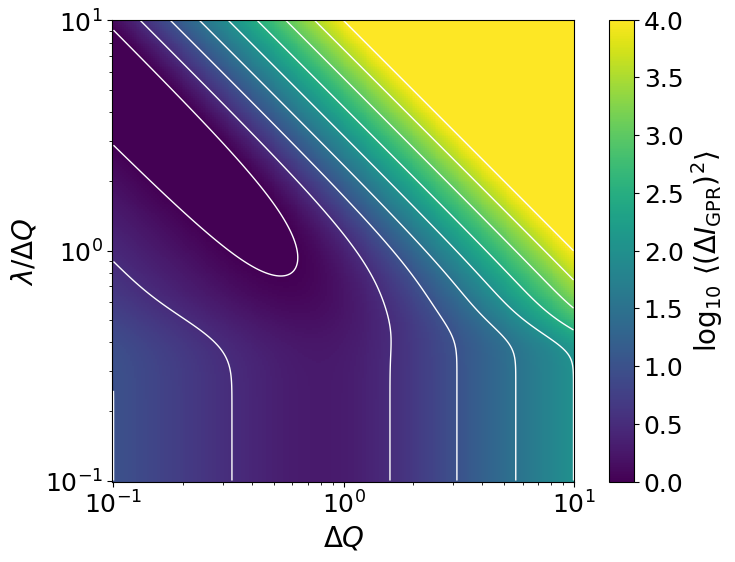

In [4]:
# Build grids
dQ_vals = np.logspace(-1, 1, 241)
rho_vals = np.logspace(-1, 1, 241)

# Evaluate the function on the grid
Z = np.empty((rho_vals.size, dQ_vals.size), dtype=float)

for i, rho in enumerate(rho_vals):
    G = G_of_rho(rho)
    # Precompute M2 or mu2 factor depends on dQ
    for j, dQ in enumerate(dQ_vals):
        mu2 = mu2_of_rho(rho, dQ)
        val = G / dQ + dQ**2 + (mu2**2)
        # Ensure strictly positive for log plotting
        Z[i, j] = max(val, 1e-300)

# Create contour of log10(Z) with log-log axes
X, Y = np.meshgrid(dQ_vals, 1/rho_vals)

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(7, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1], wspace=0.05)

ax = fig.add_subplot(gs[0])
CS = ax.contour(X, Y, np.log10(Z), levels=np.linspace(0, 4, 9), colors='w', linewidths=1)
CSf = ax.pcolormesh(X, Y, np.log10(Z), vmax=4, vmin=0)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\Delta Q$', fontsize=20)
ax.set_ylabel(r'$\lambda/\Delta Q$', fontsize=20)
ax.set_aspect('equal', adjustable='box')
ax.tick_params(axis='both', which='major', labelsize=18)

cax = fig.add_subplot(gs[1])
cbar = plt.colorbar(CSf, cax=cax)
cbar.set_label(r'$\log_{10}\,\langle(\Delta I_{\mathrm{GPR}})^2\rangle$', fontsize=20)
cbar.ax.tick_params(labelsize=18)

plt.tight_layout()
plt.show()